In [317]:
import time
import warnings
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import seaborn as sns

# Ugly hack to get to utils, which for some reason doesn't work in a notebook...
sys.path.insert(0, os.path.abspath('..'))
from utils import data_utils

In [318]:
# get my attributes and unit types (as labels)
# This data is generated in "explore_dumped_replays.ipynb", about halfway down
X, y = data_utils.unit_pickle_to_xy('/media/asilva/HD_home/my_sc_data/sc_units.pkl')

# Most of this notebook is adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
# And some of my PCA stuff from long ago in the gt-rail codebase

In [319]:
plot_num = 1
params = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 2,
                'n_clusters': 15}

In [320]:
n_comp = 15

def pca_plot(X, Y, n_labels, title='SC', do_heatmap=True, do_variance=True):
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X)
    
    colors = ['aqua', 'blue', 'black', 'red', 'darkgreen', 'red', 'magenta', 'darkblue', 'fuchsia',
             'gold', 'green', 'grey', 'ivory', 'orange', 'salmon', 'violet']
    colors = colors[:n_labels]
    labels = np.arange(0, n_labels)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for color, i in zip(colors, labels):
        ax.scatter(X_pca[Y==i, 0], X_pca[Y==i, 1], X_pca[Y==i, 2], color=color, lw=2, label=i)
#     plt.subplot(1, 6, plot_num)
#     for color, i  in zip(colors, labels):
#         plt.scatter(X_pca[Y==i, 0], X_pca[Y==i, 1], color=color, lw=2, label=i)
    plt.title('PCA of ' + title + ' Clusters')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.xlim(-4, 4)
    plt.ylim(-4, 6)

    if do_heatmap:
        plt.figure(figsize=(10, 6.5))
        plt.title('Feature Importances to PCA Features')
        sns.heatmap(np.log(pca.inverse_transform(np.eye(n_comp))), cmap="hot", cbar=False)
        plt.ylabel('principal component', fontsize=20)
        plt.xlabel('original feature index', fontsize=20)
        plt.tick_params(axis='both', which='major', labelsize=18)
        plt.tick_params(axis='both', which='minor', labelsize=12)
    if do_variance:
        plt.figure(figsize=(10, 6.5))
        plt.semilogy(pca.explained_variance_ratio_, '--o')
        plt.xlabel('principal component', fontsize=20)
        plt.ylabel('explained variance', fontsize=20)
        plt.tic1k_params(axis='both', which='major', labelsize=18)
        plt.tick_params(axis='both', which='minor', labelsize=12)
        plt.figure(figsize=(10, 6.5))
        plt.semilogy(np.square(X.std(axis=0)) / np.square(X.std(axis=0)).sum(), '--o', label='variance ratio')
        plt.semilogy(X.mean(axis=0) / np.square(X.mean(axis=0)).sum(), '--o', label='mean ratio')
        plt.xlabel('original feature', fontsize=20)
        plt.ylabel('variance', fontsize=20)
        plt.tick_params(axis='both', which='major', labelsize=18)
        plt.tick_params(axis='both', which='minor', labelsize=12)
        plt.xlim([0, 20]);
        plt.legend(loc='lower left', fontsize=18)
    plt.show()
    
def lda_plot(X, Y, n_labels):
    lda = LinearDiscriminantAnalysis(n_components=n_comp, solver='svd')
    X_lda = lda.fit(X, y).transform(X)
    
    colors = ['aqua', 'blue', 'black', 'red', 'darkgreen', 'red', 'magenta', 'darkblue', 'fuchsia',
             'gold', 'green', 'grey', 'ivory', 'orange', 'salmon', 'violet']
    colors = colors[:n_labels]
    labels = np.arange(0, n_labels)
    
#     fig = plt.figure(figsize=(8, 8))
#     ax = fig.add_subplot(111, projection='3d')

#     for color, i in zip(colors, labels):
#         ax.scatter(X_lda[Y==i, 0], X_lda[Y==i, 1], X_lda[Y==i, 2], color=color, lw=2, label=i)
    plt.figure(figsize=(8, 8))
    for color, i  in zip(colors, labels):
        plt.scatter(X_lda[Y==i, 0], X_lda[Y==i, 1], color=color, lw=2, label=i)
    plt.title('LDA of SC Unit Clusters')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.axis([-4, 4, -4, 6])
    plt.show()

In [321]:
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

In [322]:
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])

In [323]:
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'],
    linkage='ward',
    connectivity=connectivity)

In [324]:
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'],
    eigen_solver='arpack',
    affinity="nearest_neighbors")

In [325]:
birch = cluster.Birch(n_clusters=params['n_clusters'])

In [326]:
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'],
    covariance_type='full')

In [327]:
clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('Birch', birch),
    ('GaussianMixture', gmm))

OUTPUT FOR ALGORITHM: MiniBatchKMeans
Cluster 0 includes:
Terran_Valkyrie Terran_Missile_Turret Zerg_Spore_Colony 
Cluster 1 includes:
Terran_Command_Center Terran_Comsat_Station Terran_Nuclear_Silo Terran_Supply_Depot Terran_Refinery Terran_Barracks Terran_Academy Terran_Factory Terran_Starport Terran_Control_Tower Terran_Science_Facility Terran_Covert_Ops Terran_Physics_Lab Terran_Machine_Shop Terran_Armory Zerg_Hatchery Zerg_Lair Zerg_Hive Zerg_Nydus_Canal Zerg_Hydralisk_Den Zerg_Defiler_Mound Zerg_Greater_Spire Zerg_Queens_Nest Zerg_Evolution_Chamber Zerg_Ultralisk_Cavern Zerg_Spire Zerg_Spawning_Pool Zerg_Creep_Colony Zerg_Extractor 
Cluster 2 includes:
Terran_Vulture Terran_Siege_Tank_Tank_Mode Zerg_Ultralisk Zerg_Guardian Zerg_Lurker Zerg_Sunken_Colony 
Cluster 3 includes:
Terran_Marine Zerg_Mutalisk Protoss_Interceptor 
Cluster 4 includes:
Terran_SCV Terran_Firebat Spell_Scanner_Sweep Terran_Medic Zerg_Zergling Zerg_Drone Zerg_Defiler Protoss_Probe Protoss_Zealot Protoss_High_T

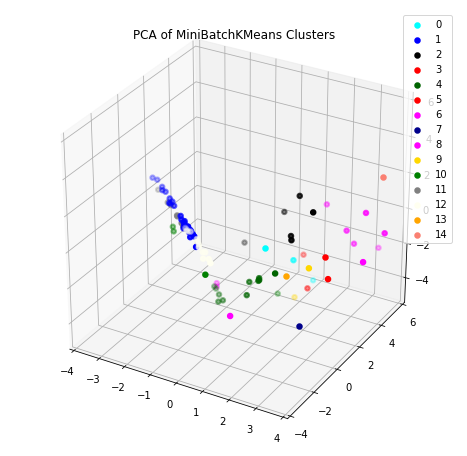



OUTPUT FOR ALGORITHM: SpectralClustering
Cluster 0 includes:
Protoss_Nexus Protoss_Assimilator Protoss_Gateway Protoss_Citadel_of_Adun Protoss_Cybernetics_Core Protoss_Templar_Archives Protoss_Forge Protoss_Stargate Protoss_Arbiter_Tribunal Protoss_Robotics_Support_Bay 
Cluster 1 includes:
Terran_Marine Terran_Goliath Terran_Wraith Terran_Battlecruiser Zerg_Hydralisk Protoss_Dragoon Protoss_Arbiter Protoss_Photon_Cannon 
Cluster 2 includes:
Terran_Science_Vessel Terran_Dropship Zerg_Overlord Zerg_Queen Terran_Bunker 
Cluster 3 includes:
Terran_SCV Terran_Vulture_Spider_Mine Terran_Firebat Zerg_Zergling Zerg_Drone Protoss_Probe Protoss_Zealot Protoss_Scarab 
Cluster 4 includes:
Terran_Refinery Terran_Academy Terran_Science_Facility Terran_Armory Zerg_Extractor 
Cluster 5 includes:
Protoss_Reaver Terran_Engineering_Bay Zerg_Nydus_Canal Zerg_Greater_Spire Zerg_Creep_Colony Protoss_Fleet_Beacon 
Cluster 6 includes:
Terran_Comsat_Station Terran_Nuclear_Silo Terran_Supply_Depot Terran_Cont

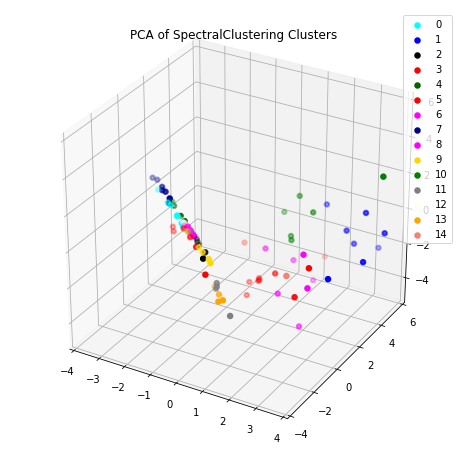



OUTPUT FOR ALGORITHM: Ward
Cluster 0 includes:
Terran_Science_Vessel Terran_Dropship Zerg_Ultralisk Zerg_Overlord Zerg_Queen Protoss_Dark_Archon Protoss_Shuttle Protoss_Carrier Terran_Comsat_Station Terran_Nuclear_Silo Terran_Supply_Depot Terran_Academy Terran_Control_Tower Terran_Covert_Ops Terran_Physics_Lab Terran_Machine_Shop Terran_Armory Terran_Bunker Zerg_Nydus_Canal Zerg_Hydralisk_Den Zerg_Defiler_Mound Zerg_Greater_Spire Zerg_Queens_Nest Zerg_Evolution_Chamber Zerg_Ultralisk_Cavern Zerg_Spire Zerg_Spawning_Pool Zerg_Creep_Colony Protoss_Pylon Protoss_Observatory Protoss_Shield_Battery 
Cluster 1 includes:
Zerg_Defiler Protoss_Corsair Protoss_Reaver Terran_Engineering_Bay Protoss_Fleet_Beacon 
Cluster 2 includes:
Terran_Valkyrie Terran_Missile_Turret Zerg_Spore_Colony 
Cluster 3 includes:
Terran_Vulture_Spider_Mine Protoss_Scarab 
Cluster 4 includes:
Protoss_Dark_Templar Protoss_Archon 
Cluster 5 includes:
Terran_Goliath Terran_Wraith Terran_Battlecruiser Zerg_Hydralisk Proto

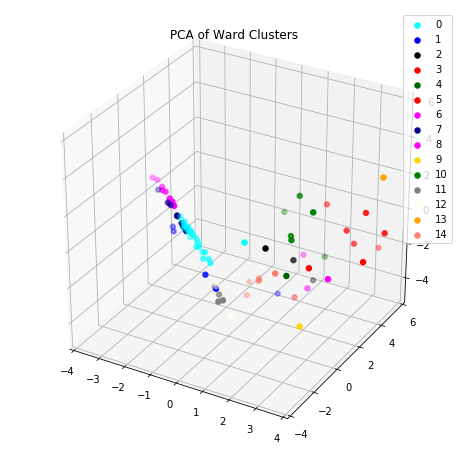



OUTPUT FOR ALGORITHM: Birch
Cluster 0 includes:
Zerg_Defiler Protoss_Corsair Protoss_Reaver 
Cluster 1 includes:
Terran_Science_Vessel Terran_Dropship Zerg_Overlord Zerg_Queen Protoss_Dark_Archon Protoss_Shuttle Protoss_Carrier Terran_Comsat_Station Terran_Nuclear_Silo Terran_Supply_Depot Terran_Academy Terran_Control_Tower Terran_Covert_Ops Terran_Physics_Lab Terran_Machine_Shop Terran_Armory Terran_Bunker Zerg_Nydus_Canal Zerg_Hydralisk_Den Zerg_Defiler_Mound Zerg_Greater_Spire Zerg_Queens_Nest Zerg_Evolution_Chamber Zerg_Ultralisk_Cavern Zerg_Spire Zerg_Spawning_Pool Zerg_Creep_Colony Protoss_Pylon Protoss_Observatory Protoss_Shield_Battery 
Cluster 2 includes:
Terran_Vulture_Spider_Mine Protoss_Scarab 
Cluster 3 includes:
Protoss_Dark_Templar Protoss_Archon 
Cluster 4 includes:
Terran_Valkyrie Terran_Missile_Turret Zerg_Spore_Colony 
Cluster 5 includes:
Terran_SCV Terran_Firebat Spell_Scanner_Sweep Terran_Medic Zerg_Zergling Zerg_Drone Protoss_Probe Protoss_Zealot Protoss_High_Te

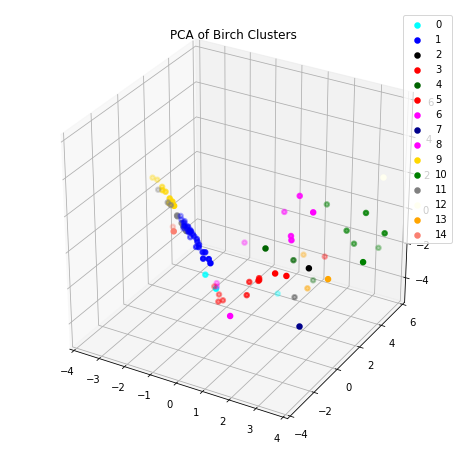



OUTPUT FOR ALGORITHM: GaussianMixture
Cluster 0 includes:
Terran_Goliath Terran_Wraith Terran_Battlecruiser Zerg_Hydralisk Protoss_Dragoon Protoss_Arbiter Protoss_Photon_Cannon 
Cluster 1 includes:
Zerg_Ultralisk Zerg_Overlord Zerg_Queen Protoss_Dark_Archon Protoss_Shuttle Protoss_Carrier Zerg_Creep_Colony Protoss_Pylon 
Cluster 2 includes:
Terran_Marine Terran_SCV Terran_Firebat Zerg_Zergling Zerg_Drone Zerg_Mutalisk Protoss_Probe Protoss_Zealot Protoss_Interceptor 
Cluster 3 includes:
Terran_Science_Vessel Terran_Dropship Terran_Command_Center Terran_Comsat_Station Terran_Nuclear_Silo Terran_Supply_Depot Terran_Refinery Terran_Barracks Terran_Academy Terran_Factory Terran_Starport Terran_Control_Tower Terran_Science_Facility Terran_Covert_Ops Terran_Physics_Lab Terran_Machine_Shop Terran_Armory Terran_Bunker Zerg_Hatchery Zerg_Lair Zerg_Hive Zerg_Nydus_Canal Zerg_Hydralisk_Den Zerg_Defiler_Mound Zerg_Greater_Spire Zerg_Queens_Nest Zerg_Evolution_Chamber Zerg_Ultralisk_Cavern Zerg_S

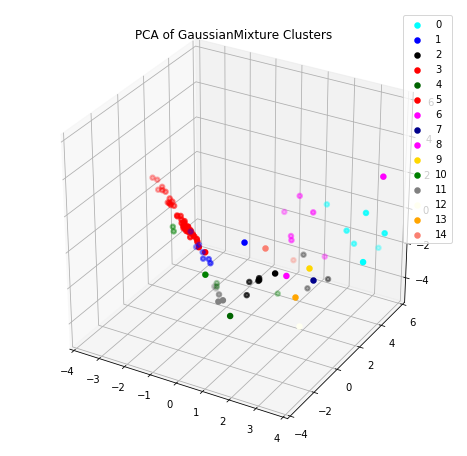

In [328]:
plt_num = 1
for name, algorithm in clustering_algorithms:
    algorithm.fit(X)

    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    print("OUTPUT FOR ALGORITHM: " + name)
    for i in range(params['n_clusters']):
        print("Cluster " + str(i) + " includes:")
        for j in range(len(y_pred)):
            if y_pred[j] == i:
                print data_utils.type_to_name(y[j]),
        print("")
    pca_plot(X, y_pred, n_labels=params['n_clusters'], title=name, do_heatmap=False, do_variance=False)
    # Division by zero in n_samples - n_classes ??
#     lda_plot(X, y_pred, n_labels=params['n_clusters'])
    plt_num += 1

    print ""
    print ""
